In [28]:
%matplotlib inline

In [29]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import sklearn
import tqdm

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [30]:
#DEVICE_ID = 3
DEVICE = torch.device('cuda:%d' % 0)
torch.cuda.set_device(0)

In [31]:
### Для запуска без GPU раскомментировать и закоментировать код выше
#DEVICE = torch.device('cpu')

In [32]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [34]:
#Надо поменять пути на свои до файлов с kaggle
#DATA_PATH  = '/Users/ilyabasharov/Programs/Projects of mail.ru/Neural networks/4 homework/'
train_path = 'kaggle_1/homework_4.train.npy'
test_path  = 'kaggle_1/homework_4_no_classes.test.npy'

In [35]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [36]:
np_mean.shape

(3,)

In [37]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [49]:
dataset_train_norm = CifarDataset(train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=125,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.001, momentum=0.9)

    
    for epoch in tqdm.tqdm_notebook(range(a_epochs)):  # loop over the dataset multiple times
        
        if (epoch == 80 ): 
            a_lr = a_lr/10
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.005, momentum=0.9) 
        if (epoch == 95 ): 
            a_lr = a_lr/10
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.005, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            new_labels = labels.to('cpu')
            epoch_accuracy += accuracy_score(new_labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [39]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        #Один из способов задать сеть - это задать последовательность слоев через Sequential
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(500, 300))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(300, 100))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = x.view((x.size()[0], -1))
        x = self.classifier(x)
        return x

In [40]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        ### Другой способ задания сети - это описать слои и в forward их применять явно
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [41]:
def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def conv1x1(a_in_planes, a_out_planes, a_stride=1):
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=1, padding=0, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*2,
               kernel_size=1,
               stride=2,
               bias=False)

In [42]:

class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=True, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        self.make_downsample = make_downsample
        
        if make_downsample: 
            coef = 2
        else: 
            coef = 1  
        if make_downsample:
            self.conv3 = conv3x3(a_in_channels, a_in_channels*2, 2)
            self.conv1 = conv3x3(a_in_channels*2, a_in_channels*2, 1)
            self.conv2 = x_downsample(a_in_channels)
            
            self.bn1 = nn.BatchNorm2d(a_in_channels*coef)
            self.bn2 = nn.BatchNorm2d(a_in_channels*coef)
            
        else:
            self.conv3 = conv3x3(a_in_channels,a_in_channels)
            self.conv2 = conv3x3(a_in_channels,a_in_channels)
            self.bn1 = nn.BatchNorm2d(a_in_channels)
            self.bn2 = nn.BatchNorm2d(a_in_channels)
        
        self.relu1 = nn.LeakyReLU()
            
    def forward(self, x):
        if (self.make_downsample):
            if (self.use_skip_connection):
                copy_x = x
            x = self.conv3(x)
            
            x = self.bn1(x)
            x = self.relu1(x)
            
            x = self.conv1(x)
            x = self.bn2(x)
            x = self.relu1(x)
            
            if (self.use_skip_connection):
                copy_x = self.conv2(copy_x)
                x = x + copy_x
                x = self.relu1(x)
                
        else:
            if (self.use_skip_connection):
                copy_x = x
            x = self.conv2(x)
            x = self.bn1(x)
            x = self.relu1(x)
        
            x = self.conv3(x)
            x = self.bn2(x)
            x = self.relu1(x)
        
            if (self.use_skip_connection):
                x = x + copy_x
                x = self.relu1(x)
        
        return x

In [43]:
class CifarResidualBottleneckBlock(nn.Module):
    
    BOTTLENECK_COEF = 4
    
    def __init__(self, a_in_channels, make_downsample=True, use_skip_connection=True):
        super(CifarResidualBottleneckBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        if make_downsample: 
            coef = 2
        else: 
            coef = 1  
                   
        if make_downsample:
            self.conv1 = conv1x1(a_in_channels, int(a_in_channels/2), 1)
            self.conv2 = conv3x3(int(a_in_channels/2), int(a_in_channels/2), 2)
            self.conv3 = conv1x1(int(a_in_channels/2), a_in_channels*2, 1)
            self.conv4 = x_downsample(a_in_channels)
            
            self.bn1 = nn.BatchNorm2d(int(a_in_channels/2))
            self.bn2 = nn.BatchNorm2d(int(a_in_channels/2))
            self.bn3 = nn.BatchNorm2d(a_in_channels*2)
            
        else:
            self.conv1 = conv1x1(a_in_channels, int(a_in_channels/4), 1)
            self.conv2 = conv3x3(int(a_in_channels/4), int(a_in_channels/4), 1)
            self.conv3 = conv1x1(int(a_in_channels/4), a_in_channels, 1)
            self.bn1 = nn.BatchNorm2d(int(a_in_channels/4))
            self.bn2 = nn.BatchNorm2d(int(a_in_channels/4))
            self.bn3 = nn.BatchNorm2d(a_in_channels)
        
        self.relu1 = nn.LeakyReLU()
    
            
    def forward(self, x):
        if (self.make_downsample):
            if (self.use_skip_connection):
                copy_x = x
            x = self.conv1(x)
            
            x = self.bn1(x)
            x = self.relu1(x)
            
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu1(x)
            
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu1(x)
            
            if (self.use_skip_connection):
                copy_x = self.conv4(copy_x)
                x = x + copy_x
                x = self.relu1(x)
                
        else:
            if (self.use_skip_connection):
                copy_x = x
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu1(x)
        
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu1(x)
            
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu1(x)
        
            if (self.use_skip_connection):
                x = x + copy_x
                x = self.relu1(x)
            
        return x

In [44]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        #TODO нужно добавить блоков resnet и других слоев при необходимости
        
        self.features = nn.Sequential()
        
        self.features.add_module('conv3x3', conv3x3(3,32))
        self.features.add_module('bn', nn.BatchNorm2d(32))
        self.features.add_module('relu', nn.LeakyReLU())
        
        self.features.add_module('res_block1', CifarResidualBlock(32))
        self.features.add_module('res_block_1', CifarResidualBlock(64, make_downsample=False))
        self.features.add_module('res_block2', CifarResidualBlock(64))
        self.features.add_module('res_block_2', CifarResidualBlock(128, make_downsample=False))
        self.features.add_module('res_block3', CifarResidualBlock(128))
        self.features.add_module('res_block_3', CifarResidualBlock(256, make_downsample=False))
        self.features.add_module('res_block4', CifarResidualBlock(256))
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.fc_classifier = nn.Linear(512, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

In [45]:
import warnings
warnings.filterwarnings('ignore')

Epoch  0 0.0859
Epoch  1 0.176
Epoch  2 0.2289
Epoch  3 0.272
Epoch  4 0.3098
Epoch  5 0.3514
Epoch  6 0.3774
Epoch  7 0.4013
Epoch  8 0.4162
Epoch  9 0.432
Epoch  10 0.4384
Epoch  11 0.4475
Epoch  12 0.4564
Epoch  13 0.4586
Epoch  14 0.4705
Epoch  15 0.4717
Epoch  16 0.4734
Epoch  17 0.4784
Epoch  18 0.4828
Epoch  19 0.483
Epoch  20 0.4882
Epoch  21 0.4863
Epoch  22 0.4876
Epoch  23 0.4945
Epoch  24 0.4941
Epoch  25 0.4962
Epoch  26 0.4968
Epoch  27 0.495
Epoch  28 0.499
Epoch  29 0.499
Epoch  30 0.4995
Epoch  31 0.5006
Epoch  32 0.5048
Epoch  33 0.5052
Epoch  34 0.5068
Epoch  35 0.5061
Epoch  36 0.505
Epoch  37 0.5083
Epoch  38 0.5088
Epoch  39 0.5057
Epoch  40 0.5088
Epoch  41 0.5093
Epoch  42 0.5106
Epoch  43 0.5121
Epoch  44 0.5175
Epoch  45 0.5106
Epoch  46 0.5144
Epoch  47 0.511
Epoch  48 0.5119
Epoch  49 0.5121
Epoch  50 0.5211
Epoch  51 0.5131
Epoch  52 0.5156
Epoch  53 0.5156
Epoch  54 0.5148
Epoch  55 0.5162
Epoch  56 0.5137
Epoch  57 0.5127
Epoch  58 0.5208
Epoch  59 0.5156

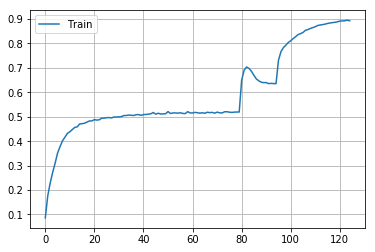

In [50]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

In [36]:
dense_net = StupidDenseNet()
%time train_network(dense_net, torch.device(DEVICE))

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1549630534704/work/aten/src/THNN/generic/ClassNLLCriterion.c:93

In [37]:
lenet = LeNet()
%time train_network(lenet, torch.device('cpu'), a_epochs=10)

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1549630534704/work/aten/src/THNN/generic/ClassNLLCriterion.c:93

In [38]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE), a_epochs=10)

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1549630534704/work/aten/src/THNN/generic/ClassNLLCriterion.c:93

Epoch  0 0.0533
Epoch  1 0.0795
Epoch  2 0.095
Epoch  3 0.099
Epoch  4 0.1006
Epoch  5 0.1037
Epoch  6 0.1041
Epoch  7 0.104
Epoch  8 0.1057
Epoch  9 0.112
Epoch  10 0.1103
Epoch  11 0.1133
Epoch  12 0.1128
Epoch  13 0.1133
Epoch  14 0.1163
Epoch  15 0.1183
Epoch  16 0.1136
Epoch  17 0.1135
Epoch  18 0.1119
Epoch  19 0.1147
Epoch  20 0.1182
Epoch  21 0.1171
Epoch  22 0.1155
Epoch  23 0.1178
Epoch  24 0.1167
Epoch  25 0.1191
Epoch  26 0.1227
Epoch  27 0.1188
Epoch  28 0.12
Epoch  29 0.1248
Epoch  30 0.1236
Epoch  31 0.1197
Epoch  32 0.1225
Epoch  33 0.1213
Epoch  34 0.121
Epoch  35 0.1208
Epoch  36 0.1169
Epoch  37 0.1221
Epoch  38 0.1196
Epoch  39 0.1267
Epoch  40 0.1246
Epoch  41 0.1199
Epoch  42 0.1199
Epoch  43 0.1251
Epoch  44 0.1237
Epoch  45 0.1254
Epoch  46 0.1237
Epoch  47 0.1274
Epoch  48 0.1263
Epoch  49 0.1244
Epoch  50 0.1241
Epoch  51 0.1264
Epoch  52 0.1277
Epoch  53 0.1269
Epoch  54 0.1231
Epoch  55 0.1254
Epoch  56 0.1277
Epoch  57 0.1242
Epoch  58 0.1283
Epoch  59 0.12

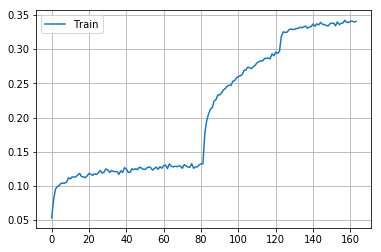

In [26]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE))

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [51]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [52]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(resnet, DEVICE)

In [53]:
with open('basharov_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)